<a href="https://colab.research.google.com/github/JiatingLi/CNN_SoybeanIDC/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input,Dense,Flatten,Activation,Conv2D,MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.initializers import TruncatedNormal
from keras_preprocessing.image import ImageDataGenerator

from matplotlib import pyplot as plt
from pandas import DataFrame
from skimage.transform import resize
from sklearn.metrics import mean_squared_error
from math import sqrt
from statistics import mean

In [ ]:
#### DATA PREPARATION
training_dir = '/content/drive/MyDrive/SoybeanIDC_CNN_Regression/Valley711_RIL/'
testing_dir = '/content/drive/MyDrive/SoybeanIDC_CNN_Regression/Valley711_NAM/'

training_label ='/content/drive/MyDrive/SoybeanIDC_CNN_Regression/Valley711_RIL.csv'
testing_label = '/content/drive/MyDrive/SoybeanIDC_CNN_Regression/Valley711_NAM.csv'
training_label = pd.read_csv(training_label, delimiter=',', header=0, names=['filename', 'IDC'])
testing_label = pd.read_csv(testing_label, delimiter=',', header=0, names=['filename', 'IDC'])

testing_y = np.array(testing_label['IDC']) #true IDC scores for testing dataset

img_width, img_height = 224, 448 

## Read data using flow_from_dataframe()
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.2)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
    dataframe=training_label,
    directory=training_dir,
    x_col='filename', 
    y_col='IDC',
    subset="training",
    batch_size=32,
    seed=22,
    shuffle=True,
    class_mode='raw',
    target_size=(img_height,img_width))

valid_generator=datagen.flow_from_dataframe(
    dataframe=training_label,
    directory=training_dir,
    x_col='filename', 
    y_col='IDC',
    subset="validation",
    batch_size=32,
    seed=22,
    shuffle=True,
    class_mode="raw",
    target_size=(img_height,img_width))

test_generator=test_datagen.flow_from_dataframe(
    dataframe=testing_label,
    directory=testing_dir,
    x_col="filename",
    y_col=None,
    batch_size=1,
    seed=22,
    shuffle=False,
    class_mode=None,
    target_size=(img_height,img_width))

Found 523 validated image filenames.
Found 130 validated image filenames.
Found 164 validated image filenames.


In [ ]:
#### Some functions
def best_fit_slope_and_intercept(xs,ys):
    m = (((mean(xs)*mean(ys)) - mean(xs*ys)) /((mean(xs)*mean(xs)) - mean(xs*xs)))
    b = mean(ys) - m*mean(xs)
    return m, b

def squared_error(y_true,y_line):
    return sum((y_line - y_true) * (y_line - y_true))

def coefficient_of_determination(y_true,y_line):
    y_mean_line = [mean(y_true) for y in y_true]
    squared_error_regr = squared_error(y_true, y_line)
    squared_error_y_mean = squared_error(y_true, y_mean_line)
    return 1 - (squared_error_regr/squared_error_y_mean)

In [ ]:
#### Define Model
inChannel = 3
input_img = Input(shape = (img_height, img_width, inChannel))

def regres(input_img):
    x = Conv2D(16, 3, kernel_initializer = TruncatedNormal(mean=0.0, stddev=0.05, seed=22),use_bias=False, padding='same')(input_img) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(16, 3, kernel_initializer = TruncatedNormal(mean=0.0, stddev=0.05, seed=22),use_bias=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    
    x = Conv2D(16, 3, kernel_initializer = TruncatedNormal(mean=0.0, stddev=0.05, seed=22),use_bias=False, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(16, 3, kernel_initializer = TruncatedNormal(mean=0.0, stddev=0.05, seed=22),use_bias=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
     
    x = Flatten()(x)
    x = Dense(100,kernel_initializer = TruncatedNormal(mean=0.0, stddev=0.05, seed=22),bias_initializer='zeros')(x)
    x = Activation('relu')(x)
    x = Dense(100,kernel_initializer = TruncatedNormal(mean=0.0, stddev=0.05, seed=22),bias_initializer='zeros')(x)
    x = Activation('relu')(x)
    x = Dense(1,kernel_initializer = TruncatedNormal(mean=0.0, stddev=0.05, seed=22),bias_initializer='zeros')(x)
    pred = Activation('linear')(x)
    return pred 

full_model = Model(input_img,regres(input_img))
full_model.compile(loss='mean_squared_error', metrics=['mean_squared_error'], optimizer=Adam(lr=0.0001))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
16/16 [==============================] - 229s 14s/step - loss: 4.4934 - mean_squared_error: 4.4934 - val_loss: 20.9858 - val_mean_squared_error: 20.9858
Epoch 2/100
16/16 [==============================] - 110s 7s/step - loss: 1.1364 - mean_squared_error: 1.1364 - val_loss: 20.8765 - val_mean_squared_error: 20.8765
Epoch 3/100
16/16 [==============================] - 114s 7s/step - loss: 0.6919 - mean_squared_error: 0.6919 - val_loss: 20.3822 - val_mean_squared_error: 20.3822
Epoch 4/100
16/16 [==============================] - 110s 7s/step - loss: 0.3879 - mean_squared_error: 0.3879 - val_loss: 20.3253 - val_mean_squared_error: 20.3253
Epoch 5/100
16/16 [==============================] - 109s 7s/step - loss: 0.2710 - mean_squared_error: 0.2710 - val_loss: 20.2596 - val_mean_squared_error: 20.2596
Epoch 6/100
16/16 [==============================] - 109s 7s/step - loss: 0.1830 - mean_squared_error: 0.1830 - val_loss: 19.9335 - val_mean_squared_error: 19.9335
Epoch 7/100
16/

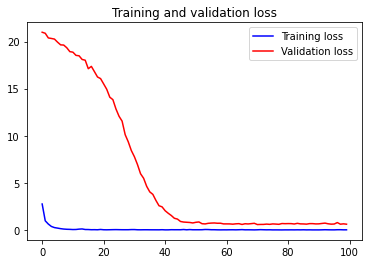

In [ ]:
#### TRAIN model
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

regressor = full_model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=100)

## plot training process
loss = regressor.history['loss']
val_loss = regressor.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


164/164 [==============================] - 57s 350ms/step
r2: 0.500
RMSE: 1.668


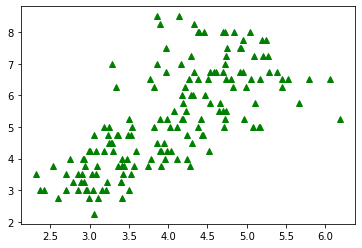

In [ ]:
#### PREDICTION
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()

predict=full_model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)

pred = predict[:,0]
true = testing_y
plt.plot(pred,true, 'g^')

# r2 and rmse 
m, b = best_fit_slope_and_intercept(pred,true)
regression_line = [(m*x)+b for x in pred]
r2 = coefficient_of_determination(true, regression_line)
rmse = sqrt(mean_squared_error(true, pred))
print('r2: %.3f' % r2)
print('RMSE: %.3f' % rmse)

# ## save
# df = DataFrame([true,pred])
# df = df.T #transpose
# df.to_excel('PATH TO EXPECTED DIRECTORY.xlsx', index=False)